#Problem 1 (60 points)

While drilling and logging a highly deviated well in the direction of $S_{Hmax}$, you begin to notice breakouts in excess of $30^{\circ}$.  Wanting to take an extremely conservative approach you decided to adjust the trajectory of the well as you are already drilling with a mud weight close to the frac gradient (i.e., stabilizing the well with increased mud weight will lead to drilling induced tensile fractures and lost circulation).  What could you do to prevent breakouts in excess of $30^{\circ}$?  Support your recommendation with an explaination and figures.

Below are the reservior characteristics.  You can assume a Mohr-Coloumb failure criterion with an unconfined compressive strength of the rock of $34$ MPa and an internal friction of $\mu_I = 1$.  The Poisson ratio is $\nu = 0.2$.

$S_{Hmax} = 145$ MPa in the direction N$30^\circ$E

$S_{hmin} = 125$ MPa

$S_{v} = 70$ MPa

$P_p = P_m = 33$ MPa

**Solution**

First we'll develop some functions to perform the rotations into wellbore coordinates, compute the principle stresses, determine if the failure criterion has been violated and detect the width of wellbore breakouts.

In [1]:
import numpy as np


def compute_Sg(S, angles=(0,0,0)):
    """Rotates the stress to geographic coordinates
    
       inputs:
       S - the principle stress tensor.
       angles - the three Euler angles of rotation
       
       output:
       the stress tensor in geographic coordinates
    """
    
    alpha, beta, gamma = np.radians(angles)
    
    Rg = np.array([[np.cos(alpha) * np.cos(beta),  
                    np.sin(alpha) * np.cos(beta),  
                    -np.sin(beta)],
                   [np.cos(alpha) * np.sin(beta) * np.sin(gamma) - np.sin(alpha) * np.cos(gamma), 
                    np.sin(alpha) * np.sin(beta) * np.sin(gamma) + np.cos(alpha) * np.cos(gamma),  
                    np.cos(beta) * np.sin(gamma)],
                   [np.cos(alpha) * np.sin(beta) * np.cos(gamma) + np.sin(alpha) * np.sin(gamma), 
                    np.sin(alpha) * np.sin(beta) * np.cos(gamma) - np.cos(alpha) * np.sin(gamma),  
                    np.cos(beta) * np.cos(gamma)]])
                  
    return np.dot(Rg.T, np.dot(S,Rg))


def compute_Sb(S, angles_G=(0,0,0), angles_B=(0,0)):
    """Rotates the stress to wellbore coordinates
    
       inputs:
       S - the principle stress tensor.
       angles_G - the three Euler angles of rotation between the principle directions and
                  the geographic coordinate system.
       angles_b - the two Euler angles of rotation between the geographic coordinate system
                  and the wellbore coordinate system.
                
       
       output:
       the stress tensor in wellbore coordinates
    """
    
    delta, phi = np.radians(angles_B)
    
    Rb = np.array([[ np.cos(delta) * np.cos(phi),  np.sin(delta) * np.cos(phi), -np.sin(phi)],
                   [ -np.sin(delta), np.cos(delta),  0.0],
                   [ np.cos(delta) * np.sin(phi), np.sin(delta) * np.sin(phi), np.cos(phi)]])
    
    Sg = compute_Sg(S, angles_G)
    
    return np.dot(Rb, np.dot(Sg,Rb.T))


def compute_wellbore_stress(S, nu, theta, DP):
    """Compute the components of stress in polar coordinates in the wellbore
    
       inputs:
       S - the stress in Cartension coordinates in the wellbore reference frame.
       nu - Poisson ratio
       theta - the polar angle to evaluate the stress tensor around the wellbore
       DP - (Pm - Pp), i.e. mud wieght minus pore pressure
       
       output:
       wellbore stress componenents in polar coordinates
    """
    
    theta = np.radians(theta)
    
    sZZ = (S[2,2] -  2. * nu * (S[0,0] - S[1,1]) * np.cos(2 * theta) - 
           4. * nu * S[0,1] * np.sin(2 * theta))
    
    stt = (S[0,0] + S[1,1] - 2. * (S[0,0] - S[1,1]) * np.cos(2 * theta) - 
           4 * S[0,1] * np.sin(2. * theta) - DP)
    
    ttz = 2. * (S[1,2] * np.cos(theta) - S[0,2] * np.sin(theta))
    
    srr = DP
    
    return (sZZ, stt, ttz, srr)


def compute_max_tangent_stress(S, nu, theta, DP):
    """Compute the maximum tangential stress in the wellbore
    
       inputs:
       S - the stress in Cartension coordinates in the wellbore reference frame.
       nu - Poisson ratio
       theta - the polar angle to evaluate the stress tensor around the wellbore
       DP - (Pm - Pp), i.e. mud wieght minus pore pressure
       
       output:
       max tangential stress
    """
    
    sZZ, stt, ttz, srr = compute_wellbore_stress(S, nu, theta, DP)
    
    return 0.5 * (sZZ + stt + np.sqrt((sZZ - stt) ** 2. + 4.0 * ttz ** 2.))


def compute_min_tangent_stress(S, nu, theta, DP):
    """Compute the minimum tangential stress in the wellbore
    
       inputs:
       S - the stress in Cartension coordinates in the wellbore reference frame.
       nu - Poisson ratio
       theta - the polar angle to evaluate the stress tensor around the wellbore
       DP - (Pm - Pp), i.e. mud wieght minus pore pressure
       
       output:
       min tangential stress
    """
    
    sZZ, stt, ttz, srr = compute_wellbore_stress(S, nu, theta, DP)
    
    return 0.5 * (sZZ + stt - np.sqrt((sZZ - stt) ** 2. + 4.0 * ttz ** 2.))


def compute_breakout_width(S, Pp, Pm, nu, C0, mu, angles_G=(0,0,0), angles_B=(0,0)):
    """Compute the breakout width
    
       inputs:
       S - the stress in Cartension coordinates in the wellbore reference frame.
       Pp - pore pressure
       Pm - mud weight
       nu - Poisson ratio
       C0 - unconfined compressive strength
       angles_G - the three Euler angles of rotation between the principle directions and
                  the geographic coordinate system.
       angles_b - the two Euler angles of rotation between the geographic coordinate system
                  and the wellbore coordinate system.
       
       output:
       breakout width in degree
    """
    
    Sb = compute_Sb(S, angles_G, angles_B)
    
    Sb_eff = Sb - Pp * np.eye(3)
    
    theta = np.linspace(0, 360, num=90)
    
    #Compute min and max tangential stress at 90 locations around the wellbore
    smax = np.array([ compute_max_tangent_stress(Sb_eff, nu, i, (Pm-Pp)) for i in theta])
    smin = np.array([ compute_min_tangent_stress(Sb_eff, nu, i, (Pm-Pp)) for i in theta])
    
    #Determine if failure occurs at these 90 locations
    breakout_bool_array = C0 < (smax) - ( np.sqrt(mu ** 2 + 1) + mu ) ** 2. * (smin)
    
    #Compute the breakout width.  Because each evaluated location (i.e. the 90) represents
    #4 degree, we multiply by 2 to get the total breakout width.  (if we sample 360 we divide by 2)
    return breakout_bool_array.sum() * 2.0

In [2]:
#Input principle stress
S = np.array([[145, 0, 0],[0,125,0],[0,0,70]])
#Range of delta and phi to sample
delta = np.linspace(0, 360, num=50)
phi = np.linspace(0, 90, num=50)
#The loop over delta and phi while converting from spherical to Cartesian coordinates
res = np.array([ (np.cos(np.radians(d))*np.sin(np.radians(p)), 
                  np.sin(np.radians(d))*np.sin(np.radians(p)), 
                  compute_breakout_width(S, 33, 33, 0.2, 34, 1.0, angles_G=(30,0,0), angles_B=(d,p))) 
                  for d in delta for p in phi])

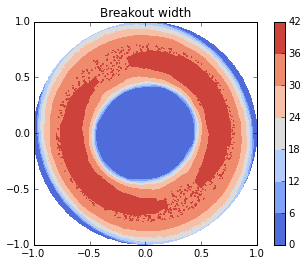

In [3]:
#Create plot
import scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib inline

#We need to interpolate the data to a regular grid.  We define the grid we 
#interpolate on
x = np.linspace(-1,1, num=500)
y = np.linspace(-1,1, num=500)
grid_x, grid_y = np.meshgrid(x,y)

#Perform the interpolation
X = res[:,0]
Y = res[:,1]
disp_x = scipy.interpolate.griddata((X, Y), res[:,2], (grid_x, grid_y), method='linear')

#Plot the figure
plt.figure()
plt.gca().set_aspect('equal')
plt.contourf(grid_x, grid_y, disp_x, cmap="coolwarm")
plt.colorbar();
plt.title("Breakout width");

The areas in blue are the "safe" zones that would be below the $30^\circ$ maximum breakout width.